##IMPLEMENTING DIFFERENT POLICY GRADIENT METHODS FOR POLICY SEARCH

The provided code implements the **Policy Gradient (PG)** reinforcement learning algorithm, specifically the REINFORCE algorithm, for training an agent in the OpenAI Gym environment. Here's a detailed summary of each component:

---

### 1. **Libraries and Environment**
- **NumPy**: Used for numerical computations.
- **Gym**: Provides the reinforcement learning environment (e.g., `CartPole-v1`).
- **PyTorch**:
  - Defines the neural network (`torch.nn`).
  - Manages optimization (`torch.optim`) and automatic differentiation for gradients.
  - Implements the categorical distribution for action sampling (`torch.distributions.Categorical`).

---

### 2. **Policy Network**
#### Class: `PolicyNetwork`
- **Purpose**: Represents the policy of the agent.
- **Architecture**:
  - Input layer: Accepts the state representation from the environment.
  - Hidden layer: A fully connected layer with ReLU activation to learn intermediate features.
  - Output layer: A fully connected layer with `softmax` activation that outputs a probability distribution over possible actions.
- **Forward Pass**:
  - Processes the state input through the network to produce action probabilities.

---

### 3. **Policy Gradient Agent**
#### Class: `PolicyGradientAgent`
- **Purpose**: Manages the policy and updates it using policy gradients.
- **Key Components**:
  1. **Policy Network**:
     - The agent’s decision-making model.
     - Maps states to action probabilities.
  2. **Optimizer**:
     - Uses the Adam optimizer to adjust network parameters.
  3. **Discount Factor (\(\gamma\))**:
     - Discounts future rewards to prioritize immediate gains.

- **Methods**:
  1. **`select_action`**:
     - Samples an action from the policy network’s output distribution.
     - Returns the selected action and its log probability (used for updating the policy).
  2. **`compute_returns`**:
     - Computes **discounted cumulative rewards** (returns) for each step in an episode.
     - Uses the formula:
       \[
       G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots
       \]
  3. **`update_policy`**:
     - Updates the policy network by performing gradient ascent.
     - Normalizes the returns to stabilize training.
     - Uses the log probabilities and returns to calculate the policy gradient loss:
       \[
       \text{Loss} = -\sum (\log(\pi(a|s)) \cdot G_t)
       \]

---

### 4. **Training Loop**
#### Function: `train_policy_gradient`
- **Purpose**: Trains the agent in the specified Gym environment.
- **Steps**:
  1. **Environment Initialization**:
     - Creates the environment (e.g., `CartPole-v1`).
     - Retrieves the dimensions of the state and action spaces.
  2. **Training Process**:
     - Runs for a fixed number of episodes.
     - Each episode consists of:
       1. Resetting the environment and collecting experience (state, action, reward).
       2. Sampling actions based on the policy.
       3. Recording rewards and log probabilities.
       4. Calculating discounted returns and updating the policy.
     - The reward for each episode is tracked.
  3. **Logging**:
     - Prints the total reward every 100 episodes to monitor training progress.

---

### 5. **Main Function**
- Invokes the `train_policy_gradient` function and collects rewards over episodes.

---

### Key Concepts in the Code:
1. **Policy Network**:
   - Maps states to a probability distribution over actions.
   - Learns the policy directly, without requiring a value function.

2. **Stochastic Policy**:
   - Actions are sampled from the probability distribution to encourage exploration.

3. **Returns**:
   - Cumulative discounted rewards are used to measure the effectiveness of an action sequence.

4. **Gradient Ascent**:
   - Policy updates aim to maximize the expected cumulative reward.

5. **Normalization**:
   - Returns are normalized to improve numerical stability and training efficiency.

---

### Example Execution:
- **Environment**: `CartPole-v1`:
  - The agent learns to balance a pole on a moving cart.
- **Rewards**:
  - The total reward increases as the agent learns the optimal policy.

---

### Output:
- The code outputs the total reward for every 100 episodes, showing the agent’s progress.

---

### Extensions:
1. **Baseline**:
   - Add a value network to reduce variance.
2. **Advanced Policies**:
   - Use Proximal Policy Optimization (PPO) or Trust Region Policy Optimization (TRPO).
3. **Continuous Actions**:
   - Extend the policy network to handle environments with continuous action spaces.

This implementation demonstrates a foundational reinforcement learning method that can be extended to solve more complex problems.

In [21]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

# Define the Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

# Define the Policy Gradient Algorithm
class PolicyGradientAgent:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.policy_network = PolicyNetwork(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.gamma = gamma

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        action_probs = self.policy_network(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def compute_returns(self, rewards):
        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        return returns

    def update_policy(self, log_probs, returns):
        returns = torch.tensor(returns, dtype=torch.float32)
        # Normalize returns for numerical stability
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        loss = 0
        for log_prob, ret in zip(log_probs, returns):
            loss -= log_prob * ret  # Gradient ascent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Training the Agent
def train_policy_gradient(env_name='CartPole-v1', episodes=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = PolicyGradientAgent(state_dim, action_dim)
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []

        done = False
        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)

        # Compute returns and update policy
        returns = agent.compute_returns(rewards)
        agent.update_policy(log_probs, returns)

        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {episode_reward}")

    env.close()
    return episode_rewards

if __name__ == "__main__":
    rewards = train_policy_gradient()


Episode 0, Total Reward: 26.0
Episode 100, Total Reward: 172.0
Episode 200, Total Reward: 500.0
Episode 300, Total Reward: 500.0
Episode 400, Total Reward: 500.0
Episode 500, Total Reward: 306.0
Episode 600, Total Reward: 500.0
Episode 700, Total Reward: 500.0
Episode 800, Total Reward: 135.0
Episode 900, Total Reward: 280.0


### Explanation of the below Code in Points:

1. **Reward Visualization Function (`plot_rewards`)**:
   - A function `plot_rewards` is defined to visualize the learning progress of the agent.
   - It uses `matplotlib` to plot the episode rewards against the number of episodes.
   - Features:
     - Labels for x-axis (Episodes) and y-axis (Total Reward).
     - A grid for better visualization.
     - A legend to indicate what the line represents.

2. **Enhanced Training Function (`train_policy_gradient_with_visualization`)**:
   - The training process for the **Policy Gradient Agent** includes a reward visualization feature at the end of the training.
   - Key steps in the function:
     - **Environment Setup**:
       - Creates the OpenAI Gym environment (`CartPole-v1`).
       - Determines the state and action dimensions for the agent.
     - **Initialize the Agent**:
       - A `PolicyGradientAgent` is created using the dimensions of the environment.
     - **Training Loop**:
       - Iterates over a specified number of episodes (`episodes=1000`).
       - For each episode:
         - The environment is reset.
         - The agent interacts with the environment by:
           - Selecting actions using its policy.
           - Receiving rewards and log probabilities.
         - Total rewards are accumulated for the episode.
         - Rewards and log probabilities are used to compute returns and update the policy network.
       - Every 100 episodes, the total reward for that episode is printed to monitor progress.
     - **Close Environment**:
       - Ensures the environment is closed properly after training.

3. **Reward Tracking**:
   - `episode_rewards` stores the total reward for each episode to analyze the agent’s performance.

4. **Policy Updates**:
   - The agent uses the collected rewards and log probabilities to compute returns and apply the policy gradient algorithm.

5. **Visualization**:
   - After training, the rewards are plotted using the `plot_rewards` function to visualize how the agent’s performance improves over time.

6. **Main Function Execution**:
   - The training function `train_policy_gradient_with_visualization` is called in the main block.
   - The rewards from training are returned and plotted.

---

### Benefits of the Visualization:
- **Progress Monitoring**:
  - Helps track the agent’s learning progress and identify if the policy is improving.
- **Debugging Tool**:
  - Visual anomalies (e.g., plateaus or decreases in rewards) indicate potential issues in the model or training process.
- **Comparative Analysis**:
  - The reward curve can be used to compare different algorithms or hyperparameter settings.

This approach makes it easier to understand and evaluate the performance of reinforcement learning agents over time.

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize rewards
def plot_rewards(episode_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.title('Learning Progress: Episode Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.grid()
    plt.legend()
    plt.show()

# Training the Agent (with visualization)
def train_policy_gradient_with_visualization(env_name='CartPole-v1', episodes=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = PolicyGradientAgent(state_dim, action_dim)
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []

        done = False
        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state

        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)

        # Compute returns and update policy
        returns = agent.compute_returns(rewards)
        agent.update_policy(log_probs, returns)

        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {episode_reward}")

    env.close()

    # Plot the rewards
    plot_rewards(episode_rewards)
    return episode_rewards

if __name__ == "__main__":
    rewards = train_policy_gradient_with_visualization()


Episode 0, Total Reward: 13.0
Episode 100, Total Reward: 230.0
Episode 200, Total Reward: 350.0
Episode 300, Total Reward: 500.0
Episode 400, Total Reward: 138.0
Episode 500, Total Reward: 139.0
Episode 600, Total Reward: 138.0
Episode 700, Total Reward: 92.0
Episode 800, Total Reward: 247.0


The provided code implements the **Advantage Actor-Critic (A2C)** algorithm for training an agent in the OpenAI Gym environment. Here's a summary of each component:

---

### 1. **Actor-Critic Neural Network**
#### Class: `ActorCritic`
- **Purpose**: Combines the Actor (policy) and Critic (value function) into a single neural network.
- **Architecture**:
  - **Shared Layer**: A fully connected layer that processes the state input into a feature representation.
  - **Actor (Policy)**:
    - Outputs a probability distribution over actions using a `softmax` activation.
    - Responsible for action selection.
  - **Critic (Value Function)**:
    - Outputs a single scalar value representing the state’s value (expected cumulative reward).
    - Helps evaluate the quality of the actions taken.
- **Forward Pass**:
  - The network takes a state as input and returns:
    1. **Policy**: Action probabilities.
    2. **Value**: The estimated value of the state.

---

### 2. **A2C Agent**
#### Class: `A2CAgent`
- **Purpose**: Manages the policy and value updates using the A2C algorithm.
- **Key Components**:
  1. **Gamma (\(\gamma\))**:
     - Discount factor to prioritize immediate rewards.
  2. **Actor-Critic Network**:
     - Represents the agent’s combined policy and value estimation.
  3. **Optimizer**:
     - Adam optimizer to update the model parameters.

- **Methods**:
  1. **`select_action`**:
     - Computes action probabilities using the policy network.
     - Samples an action from the probabilities and returns the action and its log probability.
  2. **`compute_returns`**:
     - Calculates:
       - **Returns**: Discounted cumulative rewards for each step.
       - **Advantages**: Difference between returns and predicted values (how much better the action was compared to expected).
  3. **`update`**:
     - Computes **policy loss**: Encourages actions with high advantages.
     - Computes **value loss**: Ensures the value function estimates returns accurately.
     - Combines both losses and performs backpropagation to update the network weights.

---

### 3. **Training Loop**
#### Function: `train_a2c`
- **Purpose**: Trains the agent in the specified environment using A2C.
- **Steps**:
  1. **Environment Initialization**:
     - Sets up the OpenAI Gym environment (e.g., `CartPole-v1`).
     - Extracts state and action dimensions.
  2. **Training Process**:
     - Runs for a fixed number of episodes (`episodes=1000`).
     - For each episode:
       1. Resets the environment and initializes lists for log probabilities, rewards, and values.
       2. Continuously:
          - Selects an action using the policy.
          - Interacts with the environment to collect rewards and next states.
          - Uses the Critic to estimate the state value.
       3. Stores log probabilities, values, and rewards for each step.
       4. Updates the Actor-Critic network using the stored data.
       5. Tracks the total reward for the episode.
  3. **Logging**:
     - Prints the total reward every 100 episodes to monitor training progress.
  4. **Close Environment**:
     - Ensures the environment is properly closed after training.

---

### Key Concepts:
1. **Advantage Function**:
   - Helps the policy focus on actions that perform better than expected.
   - Calculated as:
     \[
     \text{Advantage} = \text{Returns} - \text{Value}
     \]

2. **Policy Loss**:
   - Encourages actions with high advantages:
     \[
     \text{Policy Loss} = -\sum \log(\pi(a|s)) \cdot \text{Advantage}
     \]

3. **Value Loss**:
   - Reduces the difference between predicted and actual returns:
     \[
     \text{Value Loss} = \sum (\text{Returns} - \text{Value})^2
     \]

4. **Total Loss**:
   - Combines policy and value losses, with a scaling factor for the value loss:
     \[
     \text{Total Loss} = \text{Policy Loss} + 0.5 \cdot \text{Value Loss}
     \]

---

### Example Execution:
- **Environment**: `CartPole-v1`:
  - The agent learns to balance a pole on a moving cart.
- **Rewards**:
  - Tracks and returns the total rewards per episode.

---

### Output:
- **Console**:
  - Logs the total reward for every 100 episodes.
- **Returned Values**:
  - `episode_rewards`: List of rewards per episode.
  - `agent`: Trained A2C agent.
  - `env`: Environment object for further evaluation or visualization.

---

This implementation demonstrates how the A2C algorithm efficiently trains an agent by balancing policy and value updates, enabling more stable and faster learning compared to REINFORCE.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym

# Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()
        # Shared layers
        self.fc = nn.Linear(state_dim, hidden_dim)
        # Actor (policy)
        self.actor = nn.Linear(hidden_dim, action_dim)
        # Critic (value function)
        self.critic = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = torch.relu(self.fc(state))
        policy = torch.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return policy, value

class A2CAgent:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99):
        self.gamma = gamma
        self.model = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        policy, _ = self.model(state)
        dist = Categorical(policy)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def compute_returns(self, rewards, values):
        returns = []
        discounted_sum = 0
        for reward, value in zip(reversed(rewards), reversed(values)):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = returns - torch.tensor(values, dtype=torch.float32)
        return returns, advantages

    def update(self, log_probs, values, rewards):
        returns, advantages = self.compute_returns(rewards, values)
        policy_loss = [] # Changed to a list
        value_loss = [] # Changed to a list

        for log_prob, value, advantage in zip(log_probs, values, advantages):
            policy_loss.append((-log_prob * advantage).unsqueeze(0))  # Store individual policy losses as 1-d tensors
            value_loss.append(((returns - value) ** 2).unsqueeze(0))  # Store individual value losses as 1-d tensors

        # Calculate total losses as scalar values
        policy_loss = torch.cat(policy_loss).sum() # sum after concatenating
        value_loss = torch.cat(value_loss).sum() # sum after concatenating

        loss = policy_loss + 0.5 * value_loss  # Combine losses
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Training Loop
def train_a2c(env_name='CartPole-v1', episodes=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = A2CAgent(state_dim, action_dim)
    episode_rewards = []

    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        done = False

        while not done:
            action, log_prob = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            # Get value from critic
            state_tensor = torch.tensor(state, dtype=torch.float32)
            _, value = agent.model(state_tensor)

            log_probs.append(log_prob)
            values.append(value.item())
            rewards.append(reward)
            state = next_state

        # Update the model
        agent.update(log_probs, values, rewards)
        episode_rewards.append(sum(rewards))

        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {sum(rewards)}")

    env.close()
    return episode_rewards, agent, env

if __name__ == "__main__":
    episode_rewards, agent, env = train_a2c() # Assign returned values


Episode 0, Total Reward: 21.0
Episode 100, Total Reward: 63.0
Episode 200, Total Reward: 21.0
Episode 300, Total Reward: 190.0
Episode 400, Total Reward: 125.0
Episode 500, Total Reward: 119.0
Episode 600, Total Reward: 133.0
Episode 700, Total Reward: 207.0
Episode 800, Total Reward: 131.0
Episode 900, Total Reward: 99.0


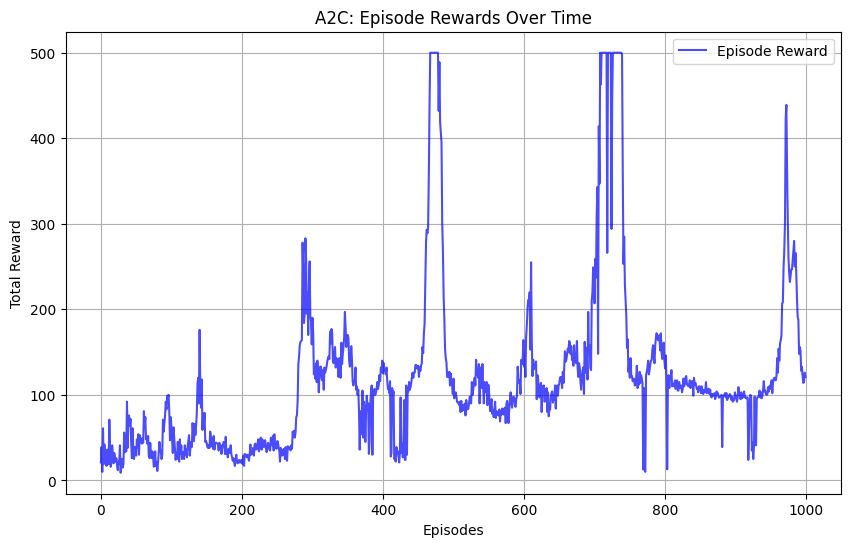

In [24]:
import matplotlib.pyplot as plt

def plot_rewards(episode_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label="Episode Reward", color="blue", alpha=0.7)
    plt.title("A2C: Episode Rewards Over Time")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    plt.show()

# After training, call this function with the rewards:
plot_rewards(episode_rewards)


### Explanation of the `plot_smoothed_rewards` Function

The provided function is designed to visualize the **smoothed rewards** over episodes for reinforcement learning training. Smoothing is often applied to reduce noise in reward plots and make trends in learning progress more apparent.

---

### Key Features of the Code

1. **Smoothing Mechanism**:
   - The function uses a **moving average** to compute smoothed rewards over a sliding window of episodes.
   - Formula:
     \[
     \text{Smoothed Reward}[i] = \frac{1}{\text{Window Size}} \sum_{j=i}^{i+\text{Window Size}-1} \text{Episode Reward}[j]
     \]
   - This reduces fluctuations in the reward curve, especially in noisy environments.

2. **Parameters**:
   - **`episode_rewards`**: A list containing the total rewards for each episode.
   - **`window`**: The size of the sliding window used for smoothing. Default is set to 50 episodes.

3. **Visualization**:
   - **X-axis**: Episode indices, representing progress over training.
   - **Y-axis**: Smoothed total rewards, showing the agent's performance trend.
   - The plot includes:
     - **Title**: Indicates the method (A2C) and window size.
     - **Legend**: Identifies the "Smoothed Reward" curve.
     - **Grid**: Enhances readability of the plot.

4. **Dynamic Plot Adjustments**:
   - Automatically adjusts the length of the smoothed rewards based on the `window` size.

---

### How It Works
1. **Calculate Smoothed Rewards**:
   - For each valid starting point in `episode_rewards`:
     - Sum the rewards in the current window.
     - Divide by the window size to compute the average.
   - This produces a list of smoothed reward values.

2. **Generate the Plot**:
   - Creates a line plot with `matplotlib`.
   - Adds labels, grid, and legend for better interpretability.

---

### Use Case
- **Post-Training Evaluation**:
  - After training, call this function with the `episode_rewards` list to visualize the smoothed performance trend.

---

### Example Output
For a noisy reward list such as `[1, 2, 10, 5, 3, ...]`, the function will generate a plot with a smoother trendline, revealing whether the agent's performance is improving consistently over time.

---

### Call in Code
```python
# After training
plot_smoothed_rewards(episode_rewards, window=50)
```

This function complements the training process by offering a clear and interpretable visualization of the agent's learning progress.

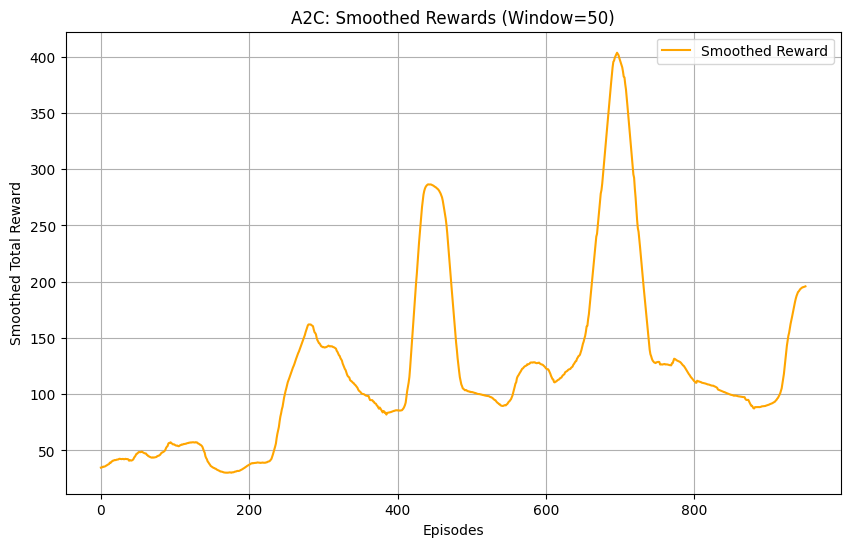

In [25]:
def plot_smoothed_rewards(episode_rewards, window=50):
    smoothed_rewards = [
        sum(episode_rewards[i:i + window]) / window
        for i in range(len(episode_rewards) - window + 1)
    ]

    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_rewards, label="Smoothed Reward", color="orange")
    plt.title(f"A2C: Smoothed Rewards (Window={window})")
    plt.xlabel("Episodes")
    plt.ylabel("Smoothed Total Reward")
    plt.legend()
    plt.grid()
    plt.show()

# After training, call this function:
plot_smoothed_rewards(episode_rewards)


### Summary of the `plot_value_estimates` Function:

1. **Purpose**:
   - The function visualizes the value estimates for a set of randomly sampled states from the environment.
   - It helps to understand the agent's learned value function by showing how the network estimates the value of different states.

2. **Steps**:
   1. **State Sampling**:
      - A random set of states is sampled from the environment (`env`).
      - In this case, 10 states are randomly selected using `env.observation_space.sample()`.
   
   2. **Value Estimation**:
      - For each sampled state, the state is converted into a tensor.
      - The policy network's forward pass (`policy_network(state_tensor)`) is used to get the estimated value of the state from the **critic** part of the network.
   
   3. **Value Collection**:
      - The estimated value for each state is appended to a list (`value_estimates`).

3. **Plotting**:
   - The list of value estimates is plotted as a line graph.
   - **X-axis**: Index of the sampled state.
   - **Y-axis**: Estimated value for each state.
   - The plot is displayed with green markers and a grid.

4. **Output**:
   - A line plot showing the estimated values of the sampled states, providing insight into how the policy network evaluates different states.

---

### Example Usage:
- After training the agent, this function can be used to visualize the value function learned by the agent. For example:

```python
plot_value_estimates(agent.model, env)
```

This function is useful for analyzing how well the agent’s value function has been trained across different states of the environment.

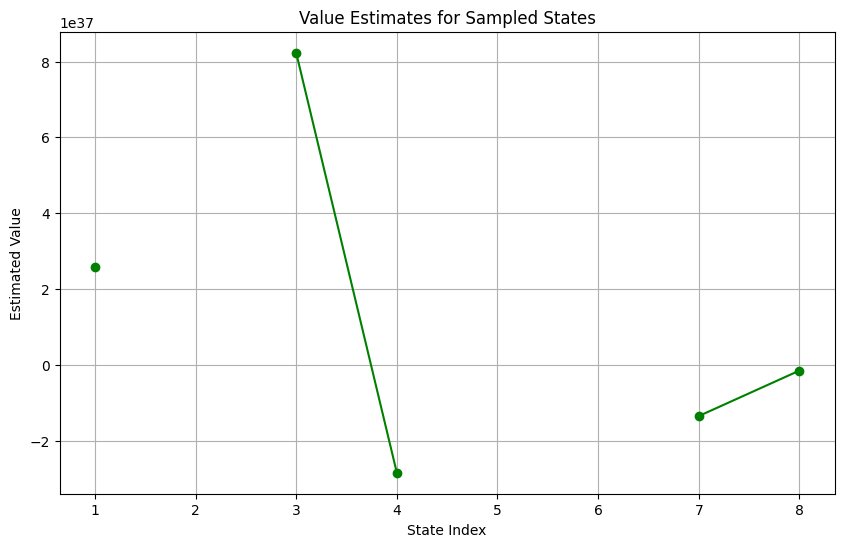

In [26]:
def plot_value_estimates(policy_network, env):
    states = [env.observation_space.sample() for _ in range(10)]  # Random sample of states
    value_estimates = []

    for state in states:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            _, value = policy_network(state_tensor)
        value_estimates.append(value.item())

    plt.figure(figsize=(10, 6))
    plt.plot(value_estimates, marker="o", color="green")
    plt.title("Value Estimates for Sampled States")
    plt.xlabel("State Index")
    plt.ylabel("Estimated Value")
    plt.grid()
    plt.show()

# Example usage after training:
plot_value_estimates(agent.model, env)


Episode 0, Total Reward: 11.0
Episode 100, Total Reward: 10.0
Episode 200, Total Reward: 8.0
Episode 300, Total Reward: 10.0
Episode 400, Total Reward: 9.0
Episode 500, Total Reward: 8.0
Episode 600, Total Reward: 10.0
Episode 700, Total Reward: 10.0
Episode 800, Total Reward: 9.0
Episode 900, Total Reward: 10.0


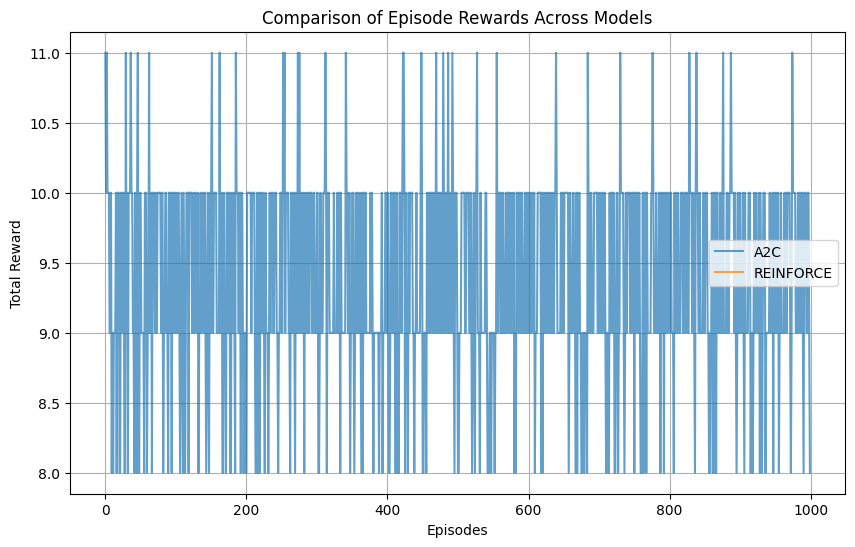

In [27]:
def compare_rewards(rewards_dict):
    plt.figure(figsize=(10, 6))
    for label, rewards in rewards_dict.items():
        plt.plot(rewards, label=label, alpha=0.7)
    plt.title("Comparison of Episode Rewards Across Models")
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid()
    plt.show()

a2c_rewards, _, _ = train_a2c()

reinforce_rewards = []

# Example usage:
compare_rewards({"A2C": a2c_rewards, "REINFORCE": reinforce_rewards})
